In [1]:
from PySDM_examples.Lowe_et_al_2019 import Settings, Simulation
from PySDM_examples.Lowe_et_al_2019.aerosol import AerosolMarine, AerosolBoreal

# !pip install -e ~/Research/PySDM
# import PySDM
# print(PySDM.__file__)
from PySDM.initialisation.sampling import spectral_sampling as spec_sampling
from PySDM.physics import si

import numpy as np
import os
from matplotlib import pyplot
import matplotlib
from joblib import Parallel, delayed, parallel_backend
import numba

In [2]:
numba.config.NUMBA_NUM_THREADS=1
rtol_x = 1e-3
rtol_thd = 1e-3

In [8]:
CI = 'CI' in os.environ

updraft_list = np.geomspace(0.1, 10, 9)
forg_list = np.linspace(0.1, 0.9, 9)

subplot_list = ["b"]
models = ('bulk', 'film')

Acc = {"a": 30, "b": 134, "c": 160, "d": 540}

In [9]:
def compute(key, settings):
    settings.output_interval = 1.0 * si.s
    settings.rtol_x = rtol_x
    settings.rtol_thd = rtol_thd
    simulation = Simulation(settings)
    output = simulation.run()
    output['updraft'] = settings.w
    output['org_fraction'] = settings.aerosol.aerosol_modes_per_cc[0]['f_org']
    output['color'] = settings.aerosol.color
    return key, output

print(f'tasks scheduled: {len(models) * len(subplot_list) * len(forg_list) * len(updraft_list)}')
with parallel_backend('loky', n_jobs=-1):
    output = dict(Parallel(verbose=10)(
        delayed(compute)(subplot+f"_w{w:.2f}_f{Forg:.2f}_"+model, Settings(
            dt = 0.1 * si.s, 
            n_sd_per_mode = 512, 
            model = model,
            aerosol = {
                "a": AerosolMarine(Acc_Forg=Forg, Acc_N2=Acc["a"]), 
                "b": AerosolMarine(Acc_Forg=Forg, Acc_N2=Acc["b"]), 
                "c": AerosolBoreal(Acc_Forg=Forg, Acc_N2=Acc["c"]), 
                "d": AerosolBoreal(Acc_Forg=Forg, Acc_N2=Acc["d"])
            }[subplot],
            w = w * si.m / si.s,
            spectral_sampling = spec_sampling.ConstantMultiplicity
        ))
        for w in updraft_list
        for Forg in forg_list
        for subplot in subplot_list
        for model in models
    ))

tasks scheduled: 162


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 13

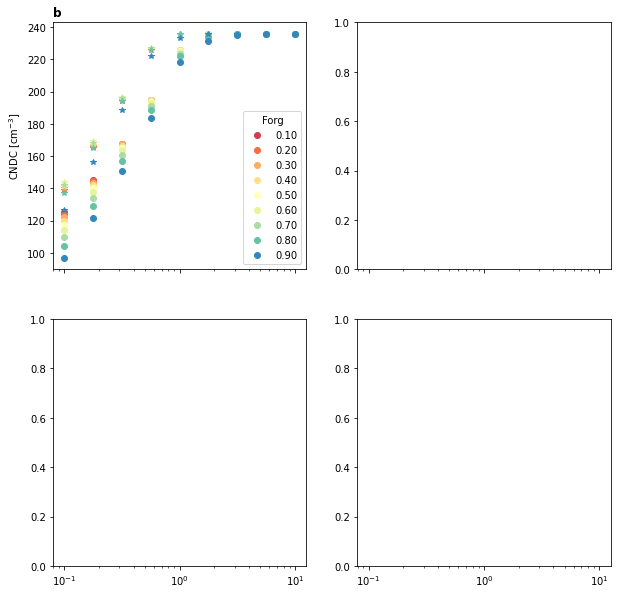

In [10]:
fig,axes = pyplot.subplots(2,2,figsize=(10,10),sharex=True,sharey=False)

f0 = open("PySDM_Marine_0.txt","w")
f1 = open("PySDM_Marine_1.txt","w")

f0.write("parcel disp = 200.00 \n")
f0.write("updraft (m/s), forg, CDNC (cm-3) \n")
f1.write("parcel disp = 200.00 \n")
f1.write("updraft (m/s), forg, CDNC (cm-3) \n")

for k,subplot in enumerate(subplot_list):
    for i,w in enumerate(updraft_list):
        for j,Forg in enumerate(forg_list):
                key = subplot+"_w{:.2f}_f{:.2f}_".format(w,Forg)
                var = 'n_c_cm3'
                z = np.array(output[key+"film"]['z'])
                CDNC_film = np.array(output[key+"film"][var])
                CDNC_bulk = np.array(output[key+"bulk"][var])
                
                ax = axes.flatten()[k]
                ax.set_title(subplot, loc="left", weight="bold")
                
                cmap = matplotlib.cm.get_cmap('Spectral')
                if i == 0:
                    ax.plot(w, CDNC_bulk[-1], 'o', color=cmap(Forg), label="{:.2f}".format(Forg))
                    ax.plot(w, CDNC_film[-1], '*', color=cmap(Forg))
                else:
                    ax.plot(w, CDNC_bulk[-1], 'o', color=cmap(Forg))
                    ax.plot(w, CDNC_film[-1], '*', color=cmap(Forg))
                
                if subplot == "b":
                    f0.write("{:.2e}, {:.2f}, {:.2f} \n".format(w, Forg, CDNC_bulk[-1]))
                    f1.write("{:.2e}, {:.2f}, {:.2f} \n".format(w, Forg, CDNC_film[-1]))
                
                ax.set_xscale("log")
                if k == 0:
                    ax.legend(title="Forg")
                    ax.set_ylabel("CNDC [cm$^{-3}$]")
                if k == 2:
                    ax.set_ylabel("CNDC [cm$^{-3}$]")
                if k > 1:
                    ax.set_xlabel("updraft velocity [m/s]")
                
pyplot.show()

f0.close()
f1.close()